In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import re
import csv
import random
from sklearn.preprocessing import LabelEncoder
import os
from gensim.models import word2vec
from sklearn.utils import shuffle
from nltk import word_tokenize



/Users/HAD/anaconda/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [3]:
#convert label to numeric vector
def label_convert(data):
    enc = LabelEncoder()
    nLabels = len(set(enc.fit(data).classes_))
    data = enc.transform(data)
    return np.eye(nLabels)[data].astype("int32")

In [4]:
#preprocess line
def process_line(line):
    return word_tokenize(line.lower())

In [5]:
#convert data to a single line for vocabulary
def convert_single_string(dataset):
    q = " "
    stringData = []
    for row in dataset:
        line = q.join(row)
        stringData.append(line)
    string = q.join(stringData)
    
    return {"single_string" : string, "lines" : stringData }

In [6]:
#plot
def plot(x1, y1, x2, y2, label1 = None, label2 = None, title = None, x_label = None, y_label = None):
    fig = plt.figure(figsize=(8,8))
    ax1 = fig.add_subplot(1,1,1)
    ax1.plot(x1, y1, color='navy', label = label1)
    ax1.tick_params(bottom='off',top='off',left='off',right='off')
    ax1.spines["right"].set_visible(False)
    ax1.spines["left"].set_visible(False)
    ax1.spines["top"].set_visible(False)
    ax1.spines["bottom"].set_visible(False)
    ax1.set(title= title, ylabel= y_label, xlabel = x_label)
    ax1.plot(x2, y2,color= 'green', label = label2)
    ax1.legend(loc= 'upper center', bbox_to_anchor=(0.5, -0.1),  shadow=True, ncol=2)
    ax1.grid()
    plt.savefig("{}.png".format(title))
    plt.show()

In [7]:
#read files
f = open('train.csv','r')
trainData = list(csv.reader(f))[1:]
f = open('test.csv','r')
testData = list(csv.reader(f)) [1:]

#shuffle training data
random.shuffle(trainData)

In [8]:
#split input and output
trainIds, trainSentences, trainTarget = zip(*trainData) 
testIds, testSentences = zip(*testData) 

In [9]:
noRows = len(trainSentences)
trainTarget = label_convert(trainTarget)

#testTarget = label_convert(testTarget)

In [10]:
#get data as list
cleanTrain = [process_line(row) for row in trainSentences]
cleanTest = [process_line(row) for row in testSentences]
whole = cleanTrain + cleanTest

In [11]:
#train word to vector
model = word2vec.Word2Vec(whole, size  = 40, window = 20, min_count=1, iter = 500)

In [103]:
#define max length for each input
maxLength = 200 #max(trainLen) # is 870
trainLen = [min(len(each), maxLength) for each in cleanTrain]
testLen = [min(len(each), maxLength) for each in cleanTest]

In [104]:
#convert numeric
#Train Data
row_count = 0
trainNumeric = np.zeros((len(cleanTrain), maxLength), dtype='int32')

for row in cleanTrain:
    index_count = 0
    for each in row:
        try:
            trainNumeric[row_count][index_count] = model.wv.vocab[each].index
        except:
            trainNumeric[row_count][index_count] = 0
        index_count += 1
        if index_count >= maxLength:
            print("Done with the Row: ", row_count)
            break       
    row_count += 1

#Test Data
row_count = 0
testNumeric = np.zeros((len(cleanTest), maxLength), dtype='int32')

for row in cleanTest:
    index_count = 0
    for each in row:
        try:
            testNumeric[row_count][index_count] = model.wv.vocab[each].index
        except:
            testNumeric[row_count][index_count] = 0
        index_count += 1
        if index_count >= maxLength:
            print("Done with the Row: ", row_count)
            break       
    row_count += 1

Done with the Row:  6
Done with the Row:  995
Done with the Row:  5614
Done with the Row:  5623
Done with the Row:  10967
Done with the Row:  11727
Done with the Row:  14420
Done with the Row:  15849
Done with the Row:  18819
Done with the Row:  1652
Done with the Row:  4833
Done with the Row:  6644


In [105]:
embeddingMatrix = np.zeros((len(model.wv.vocab), 40), dtype="float32")
for i in range(len(model.wv.vocab)):
    embeddingVector = model.wv[model.wv.index2word[i]]
    if embeddingVector is not None:
        embeddingMatrix[i] = embeddingVector

In [18]:
#store model properties
modelProperties = []

In [106]:
#Model Parameters
ValidIndexStart = 15599 #index to split some of data as test

batchSize = 400
lstmUnits = 100
keepProb = 0.75
numClasses = 3

epochs = 10
display_step = 1

In [107]:
tf.reset_default_graph()


input_data = tf.placeholder(tf.int32, [None, maxLength])

input_length = tf.placeholder(tf.int32, [None])

labels = tf.placeholder(tf.int32, [None, numClasses])

# weight & bias
W =tf.Variable(tf.random_normal([lstmUnits, numClasses]))
b = tf.Variable(tf.random_normal([numClasses]))

data = tf.nn.embedding_lookup(embeddingMatrix,input_data)


lstmCell = tf.contrib.rnn.LSTMCell(lstmUnits)
lstmCell = tf.contrib.rnn.MultiRNNCell([lstmCell] * 1)
lstmCell = tf.contrib.rnn.DropoutWrapper(cell=lstmCell, output_keep_prob= keepProb)

value, _ = tf.nn.dynamic_rnn(lstmCell, data, dtype=tf.float32, sequence_length=input_length)

word_index = tf.reshape(input_length, [tf.shape(value)[0]])-1

sentence_index = tf.range(0, tf.shape(input_data)[0]) * (tf.shape(input_data)[1])
                      
index = sentence_index + word_index

flat = tf.reshape(value, [-1, tf.shape(value)[2]])
        
last = tf.gather(flat, index)

out_layer = tf.add(tf.matmul(last,W), b)

prediction = tf.nn.softmax(out_layer)

correctPred = tf.equal(tf.argmax(prediction,1), tf.argmax(labels,1))

accuracy = tf.reduce_mean(tf.cast(correctPred, tf.float32))

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=out_layer,
                                                              labels=labels))

optimizer = tf.train.AdamOptimizer().minimize(loss)

init = tf.global_variables_initializer()


/Users/HAD/anaconda/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:96: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [108]:
#Run Model
valLoss1 = []  #results for validation loss
trainLoss1 = [] #train loss
valAcc1 = []
trainAcc1 = []

with tf.Session() as sess:
    # Initialize
    sess.run(init)
    #train model
    ValNumeric, ValLen, ValTarget = trainNumeric[ValidIndexStart+1: ], trainLen[ValidIndexStart+1: ], trainTarget[ValidIndexStart+1: ]  
    trainNumeric_, trainLen_, trainTarget_ = trainNumeric[:ValidIndexStart], trainLen[:ValidIndexStart], trainTarget[:ValidIndexStart]
    
    for epoch in range(epochs):
        nBatch = int( trainNumeric.shape[0] / batchSize )
        trainNumeric_, trainLen_, trainTarget_ = shuffle(trainNumeric_, trainLen_, trainTarget_)
        trainBatchesSentenceSplit = np.array_split(trainNumeric_, nBatch)
        trainBatchesLenSplit = np.array_split(trainLen_, nBatch)
        trainBatchesLabelSplit = np.array_split(trainTarget_, nBatch)
        
        for i in range(nBatch):
            batch = trainBatchesSentenceSplit[i]
            length = trainBatchesLenSplit[i]
            target = trainBatchesLabelSplit[i]
        # Run optimization op (backprop) and cost op (to get loss value)
            _= sess.run([optimizer], feed_dict={input_data: batch,
                                                  input_length: length,
                                                  labels: target
                                                  })
        print("Epoch Done:{}".format(epoch))
        # Display logs per epoch
        if epoch % display_step == 0:
            trainLoss, trainAcc, trainPredictionModel1 = sess.run([loss, accuracy, prediction], feed_dict = {input_data:trainNumeric_,
                                                                          input_length:trainLen_, 
                                                                          labels:trainTarget_         
                                                                           })
            print("-"*60)
            print("Epoch: {}\nTrain Batch:\nLoss:{:0.4f}\n Accuracy: {:0.3f}\n".format(epoch,trainLoss,trainAcc))
            
            # Validate model
            ValLoss, ValAcc = sess.run([loss, accuracy],feed_dict = {input_data: ValNumeric,
                                                                     input_length: ValLen,                               
                                                                     labels: ValTarget 
                                                                    })
            print("Validation Batch:\n Loss:{:0.3f}\n Accuracy:{:0.3f}".format(ValLoss,ValAcc))
            
            trainLoss1.append([epoch,trainLoss])
            trainAcc1.append([epoch,trainAcc])
            valLoss1.append([epoch,ValLoss])
            valAcc1.append([epoch,ValAcc])   
            
   
               
                
    print("Optimization Finished!")
    
    #predict test
    testPrediction = sess.run([prediction], feed_dict = {input_data: testNumeric, input_length: testLen} )    
        

Epoch Done:0
------------------------------------------------------------
Epoch: 0
Train Batch:
Loss:0.8209
 Accuracy: 0.655

Validation Batch:
 Loss:0.874
 Accuracy:0.632
Epoch Done:1
------------------------------------------------------------
Epoch: 1
Train Batch:
Loss:0.5931
 Accuracy: 0.761

Validation Batch:
 Loss:0.661
 Accuracy:0.738
Epoch Done:2
------------------------------------------------------------
Epoch: 2
Train Batch:
Loss:0.4490
 Accuracy: 0.826

Validation Batch:
 Loss:0.529
 Accuracy:0.794
Epoch Done:3
------------------------------------------------------------
Epoch: 3
Train Batch:
Loss:0.4079
 Accuracy: 0.846

Validation Batch:
 Loss:0.511
 Accuracy:0.804
Epoch Done:4
------------------------------------------------------------
Epoch: 4
Train Batch:
Loss:0.3476
 Accuracy: 0.869

Validation Batch:
 Loss:0.473
 Accuracy:0.819
Epoch Done:5
------------------------------------------------------------
Epoch: 5
Train Batch:
Loss:0.3295
 Accuracy: 0.873

Validation Bat

In [109]:
results = [valLoss1,trainLoss1,valAcc1, trainAcc1]
desc = {'Batch Size': batchSize, 'LSTM Units': lstmUnits, 'Epoch': epochs, 'Dropout': keepProb, 'Max-Length': maxLength ,'Results': results }

In [110]:
modelProperties.append(desc)

In [111]:
#plot 
plt.rcParams['font.family'] = 'Dejavu Sans'
plt.rcParams['font.size'] = 16
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['figure.titlesize'] = 12
def plots(data,name, var, xLim = 30, yLim = 1.2, header = None):
    fig = plt.figure(figsize=(12,16))
    fig.subplots_adjust(hspace= .7)
    ax1 = fig.add_subplot(2,1,1)
    ax2 = fig.add_subplot(2,1,2)
    ax1.set_ylim(0, yLim)
    ax1.set_xlim(0, xLim)
    ax2.set_ylim(0.5, 1)
    ax2.set_xlim(0, xLim)
    ax1.set_xticks(np.arange(0, xLim , 5))
    ax2.set_xticks(np.arange(0, xLim , 5))
    ax2.tick_params(bottom='off',top='off',left='off',right='off')
    ax2.spines["right"].set_visible(False)
    ax2.spines["left"].set_visible(False)
    ax2.spines["top"].set_visible(False)
    ax2.spines["bottom"].set_visible(False)
    ax2.set(title= 'Accuracy:'+ header , ylabel= 'Accuracy', xlabel = 'Epoch')
    ax1.tick_params(bottom='off',top='off',left='off',right='off')
    ax1.spines["right"].set_visible(False)
    ax1.spines["left"].set_visible(False)
    ax1.spines["top"].set_visible(False)
    ax1.spines["bottom"].set_visible(False)
    ax1.set(title= 'Loss:' + header , ylabel= 'Loss', xlabel = 'Epoch')
    for i, eachModel in enumerate(data):
        results = eachModel['Results']
        par = str(eachModel[var]) + ' ' 
        x1, y1 = zip(*results[0])
        x2, y2 = zip(*results[1])
        x3, y3 = zip(*results[2])
        x4, y4 = zip(*results[3])
        ax1.plot(x1, y1, color=plt.cm.Dark2(i), label = 'Validation Loss:'+par+var, linestyle = '--', linewidth= 2 )
        ax1.plot(x2, y2, color= plt.cm.Dark2(i ), label = 'Training Loss:' +par+var, linewidth= 2 )
        ax2.plot(x3, y3, color=plt.cm.Dark2(i ), label = 'Validation Accuracy:' +par+var,linestyle = '--' , linewidth= 2 )
        ax2.plot(x4, y4, color= plt.cm.Dark2(i ), label = 'Training Accuracy:' +par+var, linewidth= 2  )
    ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),  shadow=True, ncol=2)
    ax2.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),  shadow=True, ncol=2)
    ax1.grid()
    ax2.grid()
    
    plt.savefig("{}.png".format(name))
    plt.show()

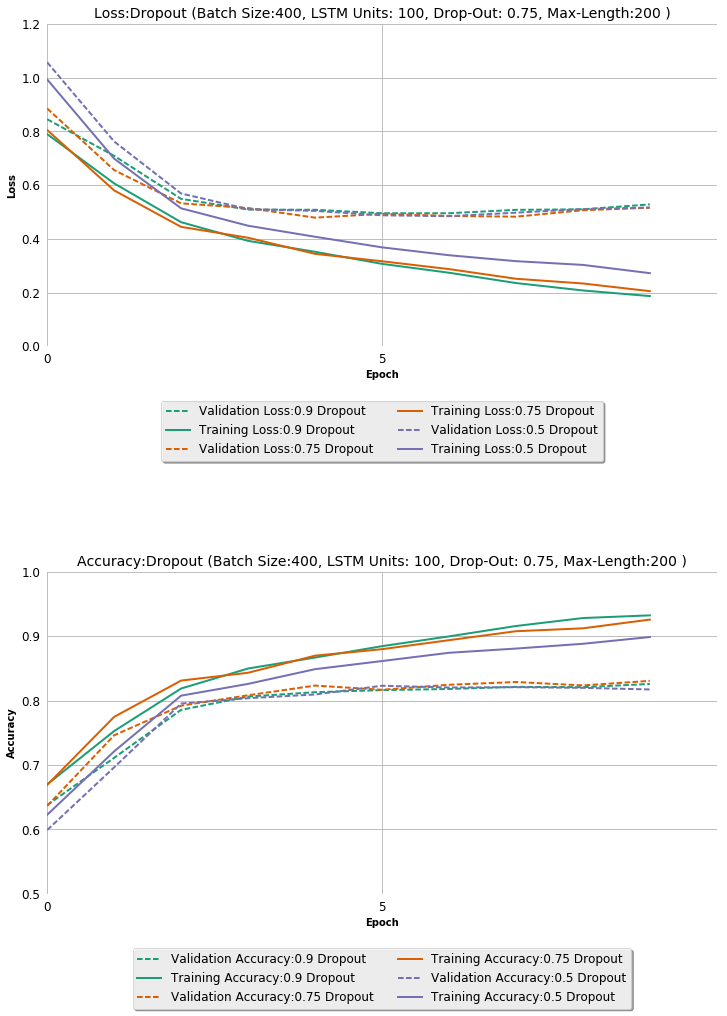

In [115]:
plots(dropoutTune,'Model Tune-1', 'Dropout', xLim = 10, yLim = 1.2, header = 'Batch Size:{}, LSTM Units: {}, Drop-Out: {}, Max-Length:{}'.format(batchSize, lstmUnits, keepProb, maxLength))

In [80]:
predictions = [] 
name = "LSTM-128-2"
for i, row in enumerate(testPrediction[0].tolist()):
    row.insert(0,testIds[i])
    predictions.append(row)
predictions.insert(0, ["id", "EAP", "HPL", "MVS"])
with open(name + ".csv", "w") as f:
    csv.writer(f).writerows(predictions)